In [1]:
from IPython.core.display import display, HTML, clear_output
display(HTML("<style>.container { width:100% !important; }</style>"))
from pathlib import Path

import pandas as pd
import numpy as np

import scipy
from scipy import optimize, integrate
from scipy import interpolate

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import container
import matplotlib.ticker as ticker
from matplotlib.ticker import NullFormatter
from matplotlib.ticker import LinearLocator, FormatStrFormatter

import time
import math
import random
import multiprocessing as mp
import os
import subprocess
from shutil import copyfile

import modules_ns_bim_spherical.geometry as geom
import modules_ns_bim_spherical.monomer_spheres as mono_s
import modules_ns_bim_spherical.monte_carlo_functions as mc_func
import modules_ns_bim_spherical.v2_ns_bim_helper_plus as helper


import seaborn as sns  

/home/chase/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# NS-BIM surface potentials

In [2]:
def plot_ns_bim_hist(ax, protein, elements_dict, label, num_bins=50, color='k', 
                     y_min_vline=0, y_max_vline=0.4, alpha=0.7):
    n_1, bins_1, rects_1 = ax.hist(elements_dict[protein]['potential_V'], 
                               num_bins, density=True, label=label, 
                               alpha=alpha, color=color)
    ax.axvline(min(elements_dict[protein]['potential_V']), y_min_vline, 
                y_max_vline, color=color, ls='--')
    ax.axvline(max(elements_dict[protein]['potential_V']), y_min_vline, 
                y_max_vline, color=color, ls='--')
    return rects_1

def plot_hist(ax, data, label, num_bins=50, color='k', y_min_vline=0, 
              y_max_vline=0.4, alpha=0.7):
    n_1, bins_1, rects_1 = ax.hist(data, num_bins, density=True, label=label, 
                                   alpha=alpha, color=color)
    ax.axvline(min(data), y_min_vline, y_max_vline, color=color, ls='--')
    ax.axvline(max(data), y_min_vline, y_max_vline, color=color, ls='--')
    return rects_1

color_1 = '#1f77b4'
color_2 = '#ff7f0e'

## Comparison of surface potentials using charge states from ProCharger and PDB2PQR

In [10]:
dir_destin = 'ns_bim_spherical/images_general/surf_pot_hist/'
dir_pro_charge = 'ns_bim_spherical/results/ns_bim_data'
dir_pdb_2_pqr  = 'ns_bim_spherical/results_pqr_charges/ns_bim_data'

protein_folders = os.listdir(dir_pro_charge)
protein_folders.sort()

In [ ]:
elem_pro_charge, node_dict, x = geom.get_elem_and_node_dicts(dir_pro_charge, protein_folders)
elem_pro_charge = geom.fill_elem_dict(elem_pro_charge, node_dict, protein_folders)

In [11]:
elem_pdb_2_pqr, node_dict, x = geom.get_elem_and_node_dicts(dir_pdb_2_pqr, protein_folders)
elem_pdb_2_pqr = geom.fill_elem_dict(elem_pdb_2_pqr, node_dict, protein_folders)

In [25]:
inds = [3, 9, 15, 21, 27, 33, 39]
inds = [i-1 for i in inds]
pois = [protein_folders[i] for i in inds]
pois

['adh_pH_7_300',
 'blg_pH_7_300',
 'cat_pH_7_300',
 'lys_pH_5_300',
 'lys_pH_7_300',
 'lys_pH_9_300',
 'ova_pH_7_300']

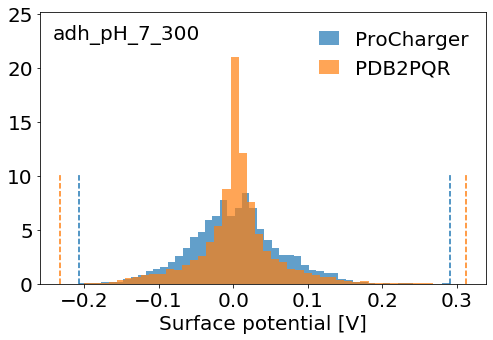

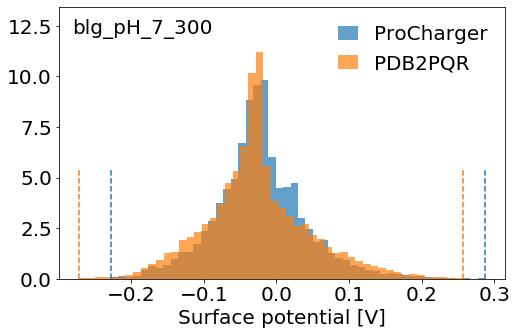

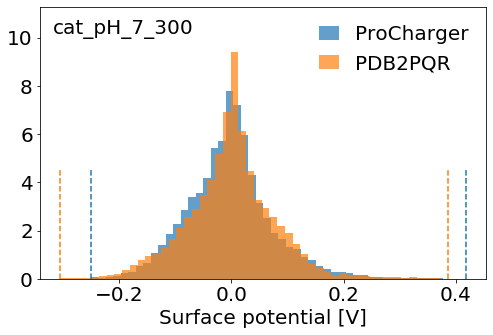

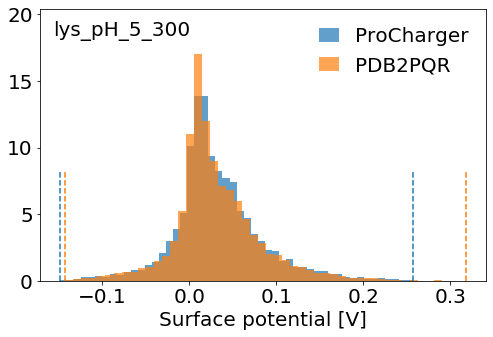

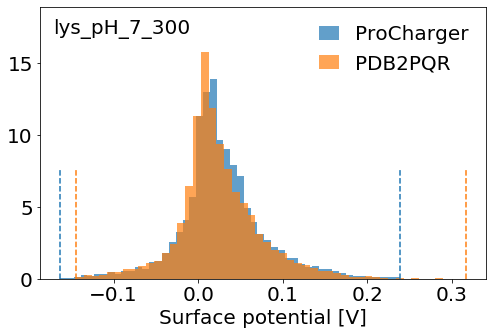

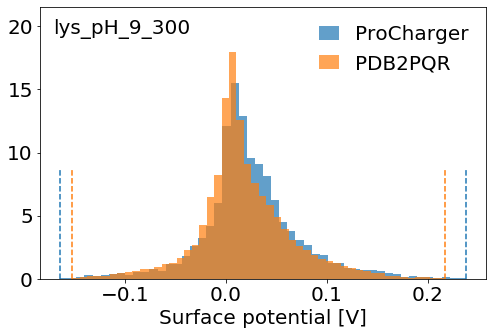

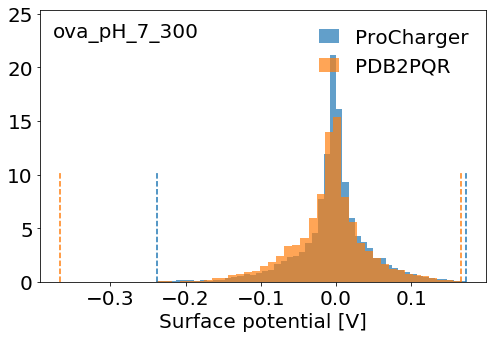

In [27]:
for protein in pois:
    fig, ax = plt.subplots()
    font = {'weight': 'normal', 'size': 20}
    plt.rc('font', **font)
    fig.set_size_inches(8, 5, forward=True)
    ax.set_xlabel('Surface potential [V]')
    ax.text(0.03, 0.9, protein, transform=ax.transAxes)

    alpha = 0.7

    rects_1 = plot_ns_bim_hist(ax, protein, elem_pro_charge, 'ProCharger', color=color_1)
    rects_2 = plot_ns_bim_hist(ax, protein, elem_pdb_2_pqr, 'PDB2PQR', color=color_2)
    
    height_max = 0
    for r in rects_1:
        height_max = max(height_max, r.get_height())
    for r in rects_2:
        height_max = max(height_max, r.get_height())
    ax.set_ylim(0, height_max*1.2)

    ax.legend(handlelength=1, frameon=False, loc='upper right')
    fig.savefig(dir_destin + protein + '.png', bbox_inches='tight', dpi=300)

## Comparison of ADH and CAT

### One sphere model

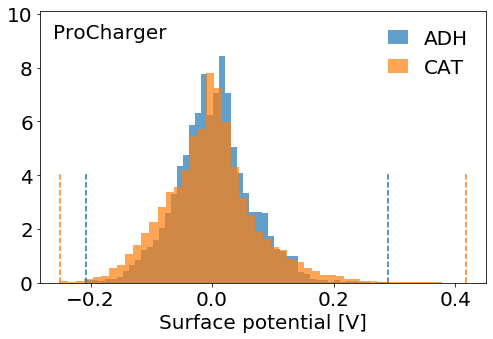

In [34]:
fig, ax = plt.subplots()
font = {'weight': 'normal', 'size': 20}
plt.rc('font', **font)
fig.set_size_inches(8, 5, forward=True)
ax.set_xlabel('Surface potential [V]')
ax.text(0.03, 0.9, 'ProCharger', transform=ax.transAxes)

alpha = 0.7

rects_1 = plot_ns_bim_hist(ax, 'adh_pH_7_300', elem_pro_charge, 'ADH', color=color_1)
rects_2 = plot_ns_bim_hist(ax, 'cat_pH_7_300', elem_pro_charge, 'CAT', color=color_2)

height_max = 0
for r in rects_1:
    height_max = max(height_max, r.get_height())
for r in rects_2:
    height_max = max(height_max, r.get_height())
ax.set_ylim(0, height_max*1.2)

ax.legend(handlelength=1, frameon=False, loc='upper right')
fig.savefig(dir_destin + 'adh_cat_ProCharger.png', bbox_inches='tight', dpi=300)

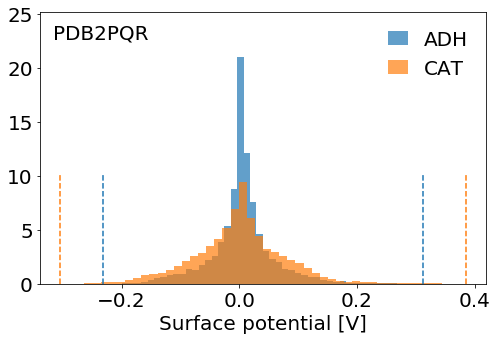

In [35]:
fig, ax = plt.subplots()
font = {'weight': 'normal', 'size': 20}
plt.rc('font', **font)
fig.set_size_inches(8, 5, forward=True)
ax.set_xlabel('Surface potential [V]')
ax.text(0.03, 0.9, 'PDB2PQR', transform=ax.transAxes)

alpha = 0.7

rects_1 = plot_ns_bim_hist(ax, 'adh_pH_7_300', elem_pdb_2_pqr, 'ADH', color=color_1)
rects_2 = plot_ns_bim_hist(ax, 'cat_pH_7_300', elem_pdb_2_pqr, 'CAT', color=color_2)

height_max = 0
for r in rects_1:
    height_max = max(height_max, r.get_height())
for r in rects_2:
    height_max = max(height_max, r.get_height())
ax.set_ylim(0, height_max*1.2)

ax.legend(handlelength=1, frameon=False, loc='upper right')
fig.savefig(dir_destin + 'adh_cat_PDB2PQR.png', bbox_inches='tight', dpi=300)

### Monomer sphere model

In [51]:
dir_prot = 'ns_bim_monomer_spheres/results/ns_bim_data/adh_pH_7_300'
df_link = mono_s.get_link(dir_prot)
df_node = mono_s.get_nodes(dir_prot)
df_prot_adh = mono_s.get_elements(df_link, df_node)

dir_prot = 'ns_bim_monomer_spheres/results/ns_bim_data/cat_pH_7_300'
df_link = mono_s.get_link(dir_prot)
df_node = mono_s.get_nodes(dir_prot)
df_prot_cat = mono_s.get_elements(df_link, df_node)


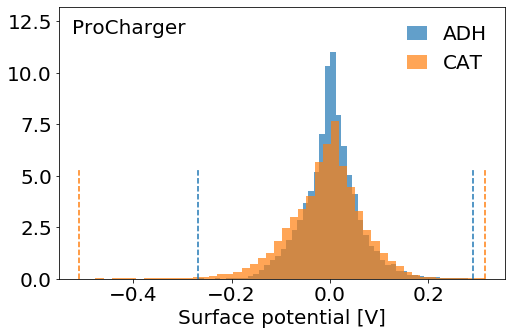

In [54]:
fig, ax = plt.subplots()
font = {'weight': 'normal', 'size': 20}
plt.rc('font', **font)
fig.set_size_inches(8, 5, forward=True)
ax.set_xlabel('Surface potential [V]')
ax.text(0.03, 0.9, 'ProCharger', transform=ax.transAxes)

rects_1 = plot_hist(ax, df_prot_adh['phi_V'], 'ADH', color=color_1)
rects_2 = plot_hist(ax, df_prot_cat['phi_V'], 'CAT', color=color_2)

height_max = 0
for r in rects_1:
    height_max = max(height_max, r.get_height())
for r in rects_2:
    height_max = max(height_max, r.get_height())
ax.set_ylim(0, height_max*1.2)

ax.legend(handlelength=1, frameon=False, loc='upper right')
fig.savefig('ns_bim_monomer_spheres/results/images/adh_cat_comparison_ProCharger.png', 
            bbox_inches='tight', dpi=300)


## Monte Carlo results - 1000 charge assignments

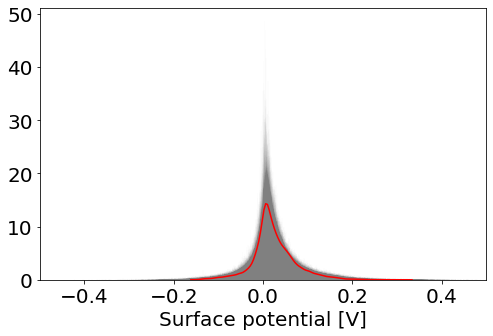

In [82]:
protein = 'lys_pH_7'

fig, ax = plt.subplots()
font = {'weight': 'normal', 'size': 20}
plt.rc('font', **font)
fig.set_size_inches(8, 5, forward=True)
ax.set_xlabel('Surface potential [V]')
ax.set_xlim(-0.5, 0.5)

ns_bim_dir  = 'ns_bim_spherical/ns_bim_programs/'
prot_dir    = ns_bim_dir + protein + '/'
pot_file    = prot_dir + 'monte_carlo_potential.csv'
df_pot = pd.read_csv(pot_file)

for i, content in df_pot.iteritems():
    ax.hist(content, 200, density=True, alpha=0.01, color='grey')

sns.kdeplot(elem_pdb_2_pqr[protein+'_300']['potential_V'], legend=False, color='red')
    
fig.savefig('ns_bim_spherical/images_general/' + protein + '_monte_carlo_potential.png',
            bbox_inches='tight', dpi=300)

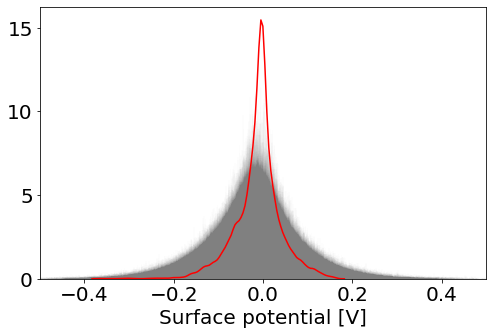

In [83]:
protein = 'ova_pH_7'

fig, ax = plt.subplots()
font = {'weight': 'normal', 'size': 20}
plt.rc('font', **font)
fig.set_size_inches(8, 5, forward=True)
ax.set_xlabel('Surface potential [V]')
ax.set_xlim(-0.5, 0.5)

ns_bim_dir  = 'ns_bim_spherical/ns_bim_programs/'
prot_dir    = ns_bim_dir + protein + '/'
pot_file    = prot_dir + 'monte_carlo_potential.csv'
df_pot = pd.read_csv(pot_file)

for i, content in df_pot.iteritems():
    ax.hist(content, 200, density=True, alpha=0.01, color='grey')

sns.kdeplot(elem_pdb_2_pqr[protein+'_300']['potential_V'], legend=False, color='red')
    
fig.savefig('ns_bim_spherical/images_general/' + protein + '_monte_carlo_potential.png',
            bbox_inches='tight', dpi=300)

## Comparison of histograms at 50 and 500 mM IS

In [3]:
dir_destin  = 'ns_bim_spherical/results_pqr_partial_charges/images/histograms/'
dir_data    = 'ns_bim_spherical/results_pqr_partial_charges/ns_bim_data'

protein_folders = os.listdir(dir_data)
protein_folders.sort()

In [4]:
elem_pro_charge, node_dict, x = geom.get_elem_and_node_dicts(dir_data, protein_folders)
elem_pro_charge = geom.fill_elem_dict(elem_pro_charge, node_dict, protein_folders)

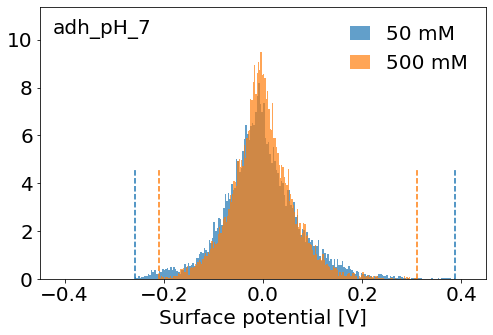

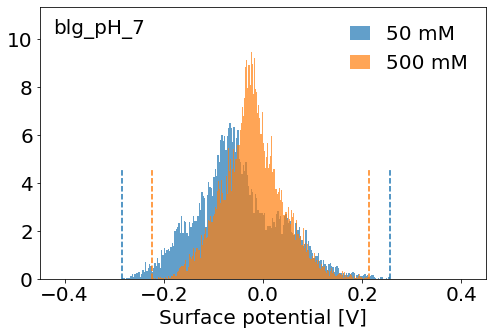

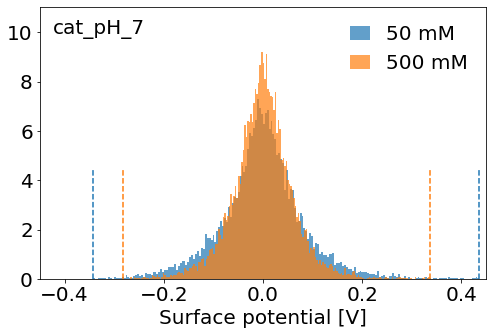

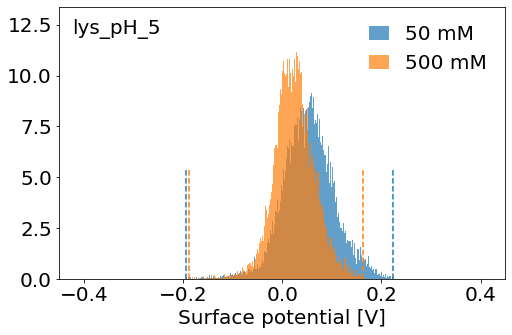

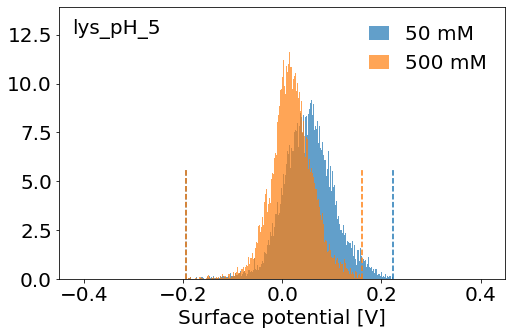

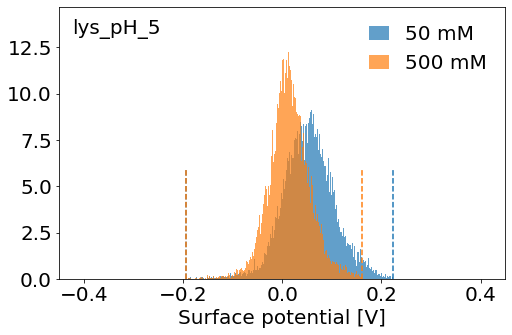

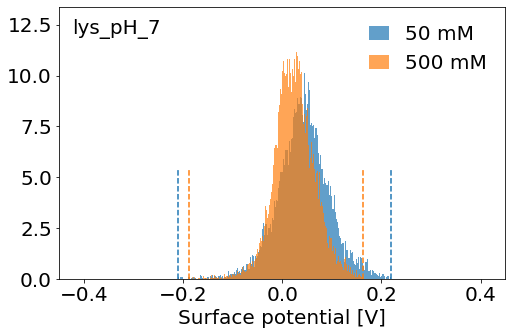

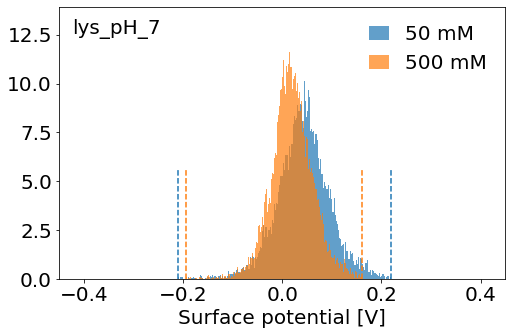

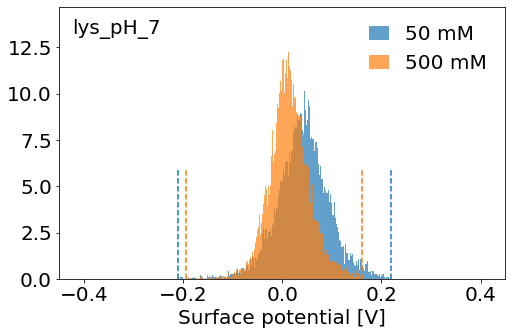

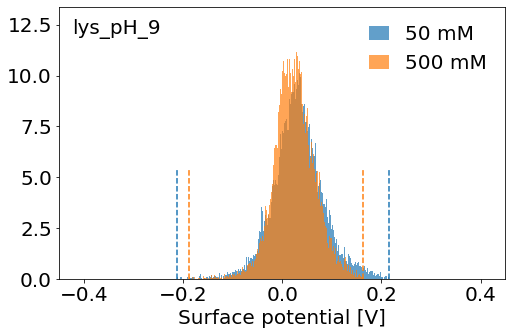

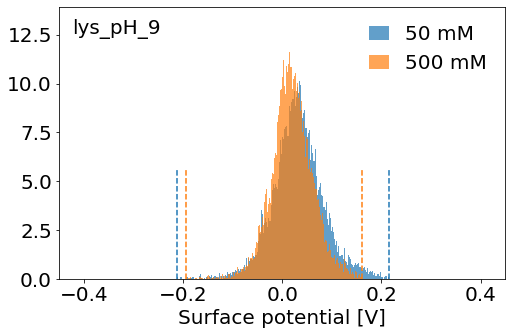

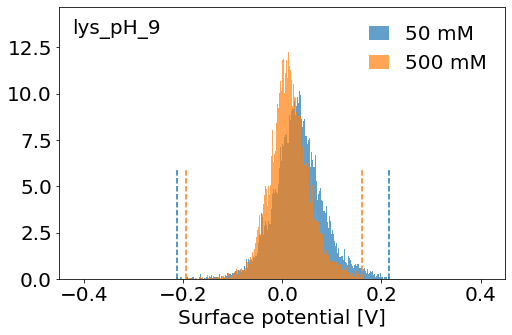

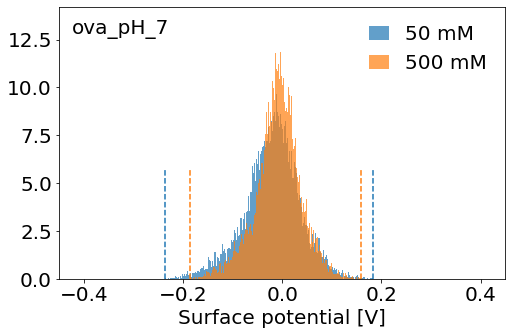

In [15]:
for p1 in protein_folders:
    if p1[-2:] != '50':
        pass
    else:
        for p2 in protein_folders:
            if p1[:3] != p2[:3] or p2[-3:] != '500':
                pass
            else:
                fig, ax = plt.subplots()
                font = {'weight': 'normal', 'size': 20}
                plt.rc('font', **font)
                fig.set_size_inches(8, 5, forward=True)
                ax.set_xlabel('Surface potential [V]')
                ax.text(0.03, 0.9, p1[:-3], transform=ax.transAxes)

                alpha = 0.7

                rects_1 = plot_ns_bim_hist(ax, p1, elem_pro_charge, '50 mM', num_bins=200, color=color_1)
                rects_2 = plot_ns_bim_hist(ax, p2, elem_pro_charge, '500 mM', num_bins=200, color=color_2)

                height_max = 0
                for r in rects_1:
                    height_max = max(height_max, r.get_height())
                for r in rects_2:
                    height_max = max(height_max, r.get_height())
                ax.set_ylim(0, height_max*1.2)
                
                ax.set_xlim(-0.45, 0.45)
                ax.legend(handlelength=1, frameon=False, loc='upper right')
                fig.savefig(dir_destin + p1[:-2] + '_fixed_lim.png', bbox_inches='tight', dpi=300)

# Monte Carlo results - 50 charge assignments
Discrete charges from .pqr files, spherical proteins

### Set up

In [36]:
def get_unique(my_list):
    my_set = set(my_list)
    return list(my_set)

In [37]:
ns_bim_dir    = 'ns_bim_spherical/ns_bim_programs/'
dir_destin    = 'ns_bim_spherical/images_general/monte_carlo/'
dir_pdb_2_pqr = 'ns_bim_spherical/results_pqr_charges/ns_bim_data'

In [10]:
protein_folders = os.listdir(dir_pro_charge)
protein_folders.sort()

elem_pdb_2_pqr, node_dict, x = geom.get_elem_and_node_dicts(dir_pdb_2_pqr, protein_folders)
elem_pdb_2_pqr = geom.fill_elem_dict(elem_pdb_2_pqr, node_dict, protein_folders)

### Choose one

In [38]:
protein = 'lys_pH_7'

In [49]:
protein = 'ova_pH_7'

### Plots

In [50]:
dir_images = dir_destin + protein + '/'
helper.my_mk_dir(dir_images)

Successfully created the directory ns_bim_spherical/images_general/monte_carlo/ova_pH_7/


In [51]:
prot_dir         = ns_bim_dir + protein + '/' 
mc_elements_dict = mc_func.mc_get_elem_dict(prot_dir)
keys             = list(mc_elements_dict.keys())
ion_strengths    = [mc_func.get_ion_str_from_key(key) for key in keys]
ion_strengths    = get_unique(ion_strengths)


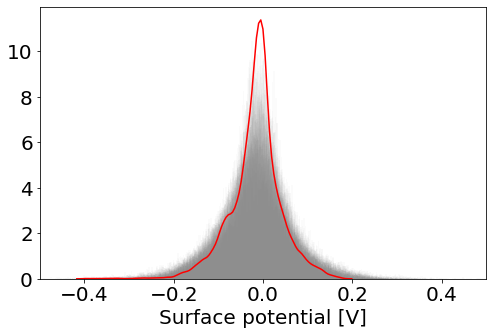

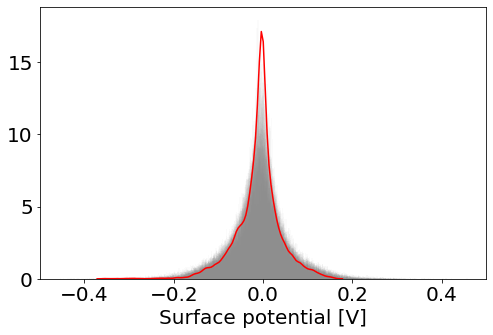

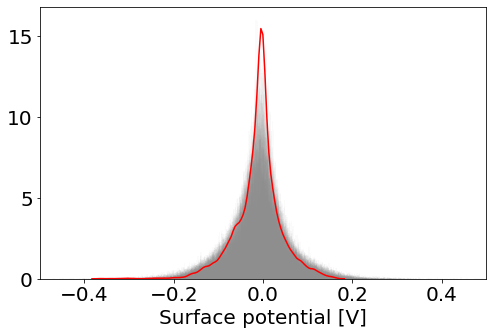

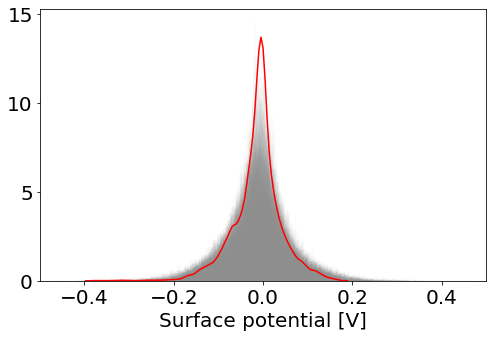

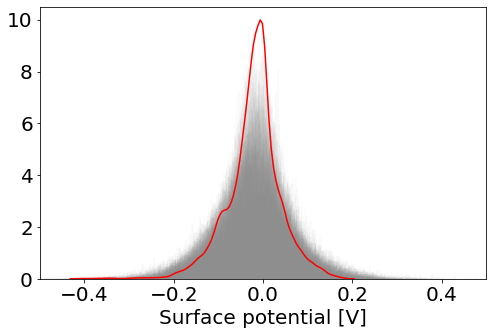

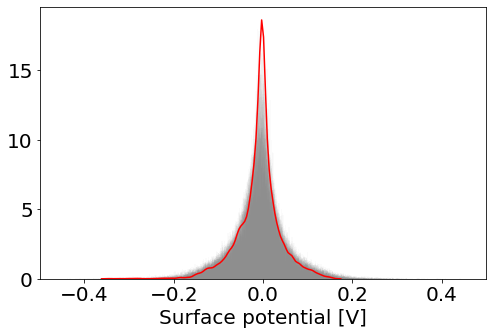

In [52]:
for ion_str in ion_strengths:
    
    fig, ax = plt.subplots()
    font = {'weight': 'normal', 'size': 20}
    plt.rc('font', **font)
    fig.set_size_inches(8, 5, forward=True)
    ax.set_xlabel('Surface potential [V]')
    ax.set_xlim(-0.5, 0.5)

    for key in keys:
        if mc_func.get_ion_str_from_key(key) == ion_str:
            pots = mc_elements_dict[key]['potential_V']
            ax.hist(pots, 200, density=True, alpha=0.03, color='grey')
    
    key_name = protein + '_' + str(int(ion_str*1e3))
    sns.kdeplot(elem_pdb_2_pqr[key_name]['potential_V'], legend=False, color='red')

    fig.savefig(dir_images + key_name + '_MC_50.png', bbox_inches='tight', dpi=300)

# Monomer Monte Carlo results - 30 charge assignments
Discrete charges from .pqr files, monomer sphere proteins

### Set up

In [9]:
n_iterations = 30
ion_str_list = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]

In [10]:
ns_bim_dir    = 'ns_bim_monomer_spheres/ns_bim_programs_pqr_mc/'
dir_pdb_2_pqr = 'ns_bim_monomer_spheres/results_pqr_partial_charges/ns_bim_data/'


### Plots

In [13]:
protein    = 'cat_pH_7'

dir_images = ns_bim_dir + protein + '/mc_keq_results/images/'
helper.my_mk_dir(dir_images)
dir_mc_res = ns_bim_dir + protein + '/mc_results/'

Successfully created the directory ns_bim_monomer_spheres/ns_bim_programs_pqr_mc/cat_pH_7/mc_keq_results/images/


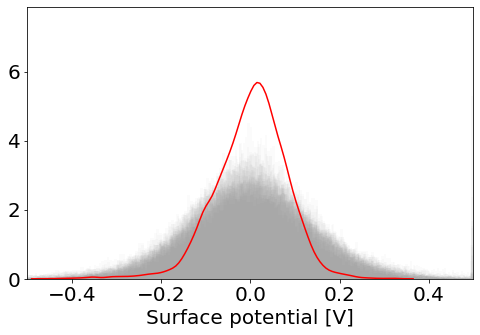

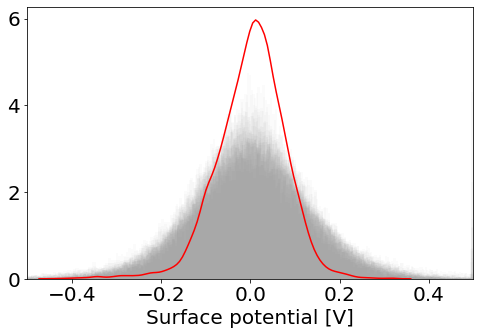

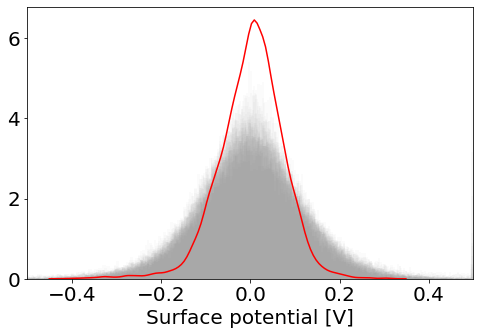

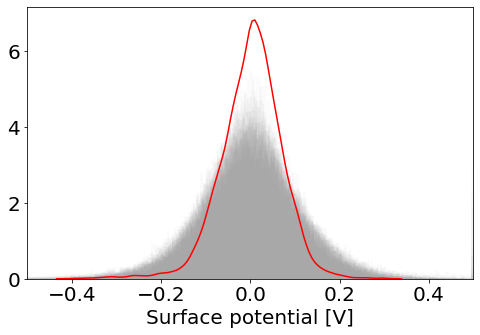

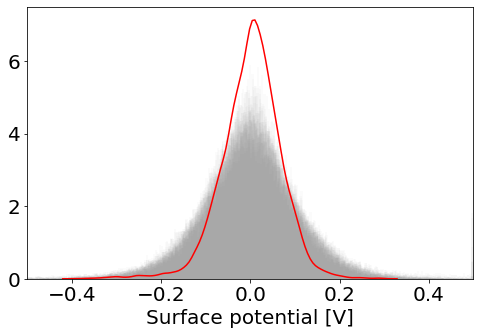

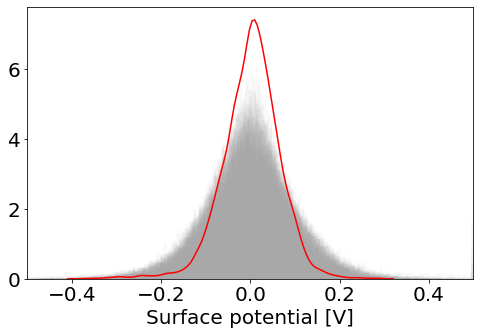

In [14]:
for ion_str in ion_str_list:
    ion_str_string = str(int(ion_str*1000))
    dir_struct = dir_pdb_2_pqr + protein + '_' + ion_str_string + '/'

    fig, ax = plt.subplots()
    font = {'weight': 'normal', 'size': 20}
    plt.rc('font', **font)
    fig.set_size_inches(8, 5, forward=True)
    ax.set_xlabel('Surface potential [V]')
    ax.set_xlim(-0.5, 0.5)
    
    for i in range(n_iterations):
        data_dir = dir_mc_res + ion_str_string + '_iteration_' + str(i) + '/'
        df       = mono_s.get_df_elem(data_dir)
        pots     = df['phi_V']
        ax.hist(pots, 200, density=True, alpha=0.03, color='grey')            
    
    df       = mono_s.get_df_elem(dir_struct)
    pots     = df['phi_V']
    sns.kdeplot(pots, legend=False, color='red')

    fig.savefig(dir_images + protein + '_' + ion_str_string + '_MC_30.png', 
                bbox_inches='tight', dpi=300)

In [ ]:
# Need to run these...

In [15]:
protein    = 'blg_pH_7'

dir_images = ns_bim_dir + protein + '/mc_keq_results/images/'
helper.my_mk_dir(dir_images)
dir_mc_res = ns_bim_dir + protein + '/mc_results/'

Creation of the directory ns_bim_monomer_spheres/ns_bim_programs_pqr_mc/blg_pH_7/mc_keq_results/images/ failed


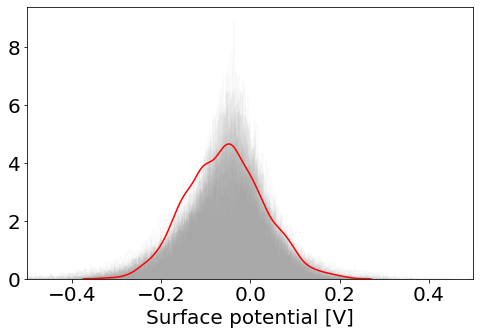

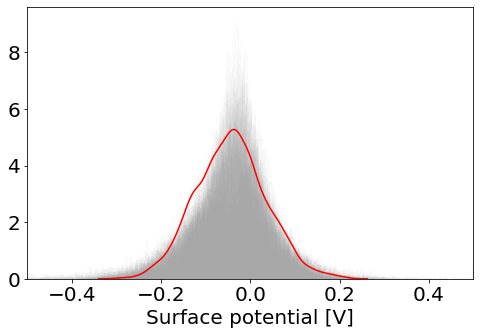

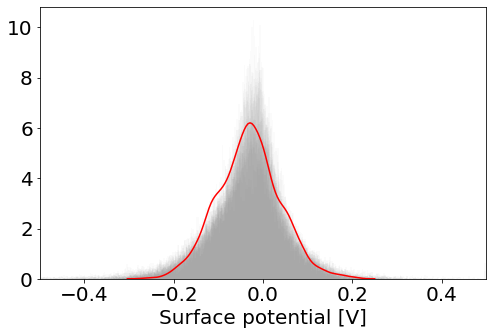

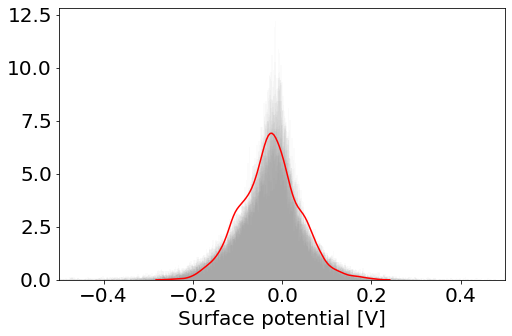

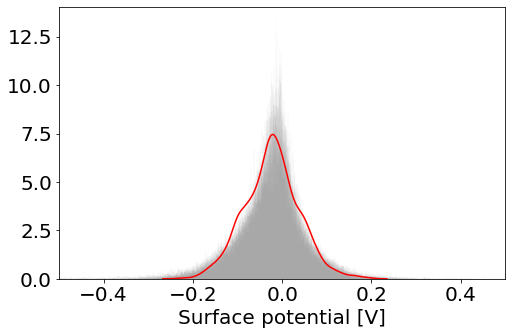

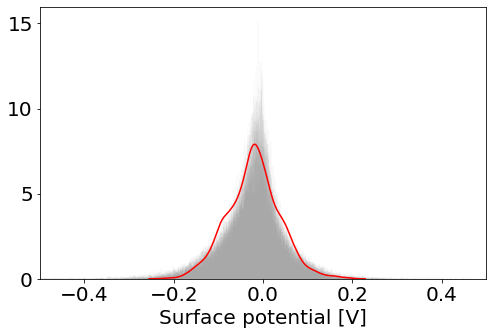

In [16]:
for ion_str in ion_str_list:
    ion_str_string = str(int(ion_str*1000))
    dir_struct = dir_pdb_2_pqr + protein + '_' + ion_str_string + '/'

    fig, ax = plt.subplots()
    font = {'weight': 'normal', 'size': 20}
    plt.rc('font', **font)
    fig.set_size_inches(8, 5, forward=True)
    ax.set_xlabel('Surface potential [V]')
    ax.set_xlim(-0.5, 0.5)
    
    for i in range(n_iterations):
        data_dir = dir_mc_res + ion_str_string + '_iteration_' + str(i) + '/'
        df       = mono_s.get_df_elem(data_dir)
        pots     = df['phi_V']
        ax.hist(pots, 200, density=True, alpha=0.03, color='grey')            
    
    df       = mono_s.get_df_elem(dir_struct)
    pots     = df['phi_V']
    sns.kdeplot(pots, legend=False, color='red')

    fig.savefig(dir_images + protein + '_' + ion_str_string + '_MC_30.png', 
                bbox_inches='tight', dpi=300)

In [17]:
protein    = 'adh_pH_7'

dir_images = ns_bim_dir + protein + '/mc_keq_results/images/'
helper.my_mk_dir(dir_images)
dir_mc_res = ns_bim_dir + protein + '/mc_results/'

Creation of the directory ns_bim_monomer_spheres/ns_bim_programs_pqr_mc/adh_pH_7/mc_keq_results/images/ failed


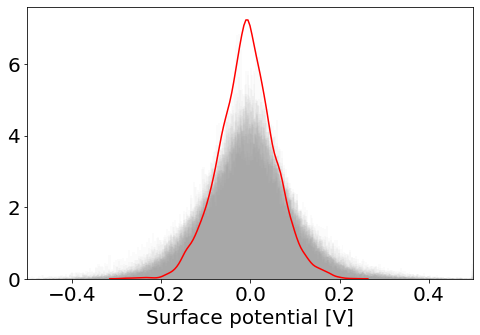

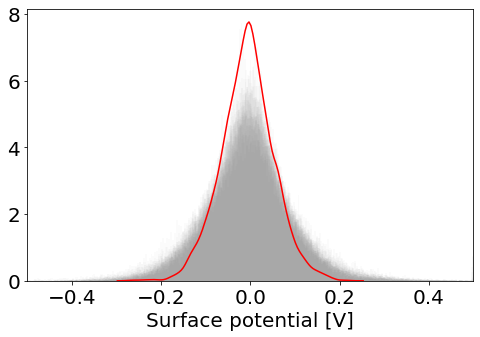

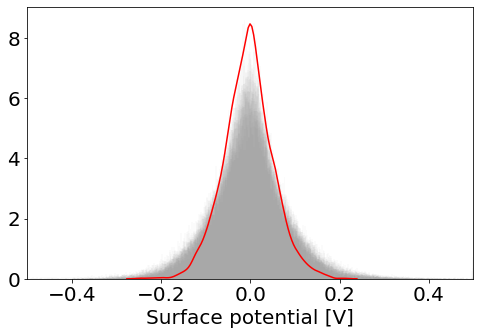

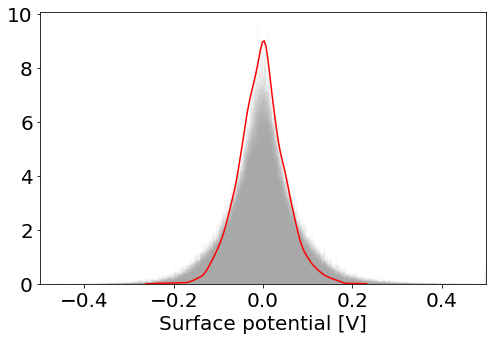

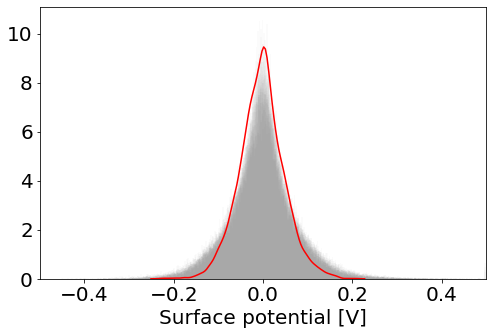

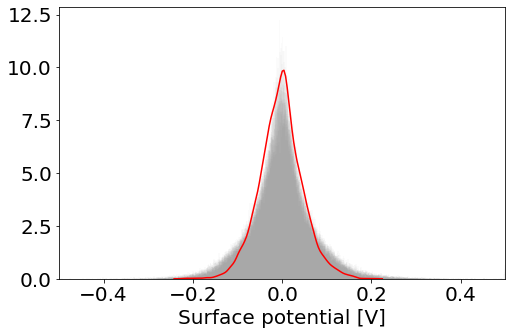

In [18]:
for ion_str in ion_str_list:
    ion_str_string = str(int(ion_str*1000))
    dir_struct = dir_pdb_2_pqr + protein + '_' + ion_str_string + '/'

    fig, ax = plt.subplots()
    font = {'weight': 'normal', 'size': 20}
    plt.rc('font', **font)
    fig.set_size_inches(8, 5, forward=True)
    ax.set_xlabel('Surface potential [V]')
    ax.set_xlim(-0.5, 0.5)
    
    for i in range(n_iterations):
        data_dir = dir_mc_res + ion_str_string + '_iteration_' + str(i) + '/'
        df       = mono_s.get_df_elem(data_dir)
        pots     = df['phi_V']
        ax.hist(pots, 200, density=True, alpha=0.03, color='grey')            
    
    df       = mono_s.get_df_elem(dir_struct)
    pots     = df['phi_V']
    sns.kdeplot(pots, legend=False, color='red')

    fig.savefig(dir_images + protein + '_' + ion_str_string + '_MC_30.png', 
                bbox_inches='tight', dpi=300)